In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from fancyimpute import KNN
import warnings
warnings.filterwarnings('ignore')
from geopy.distance import geodesic
from geopy.distance import great_circle
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.externals import joblib

Using TensorFlow backend.


In [2]:
#Set working directory
os.chdir('D:/Eduvisor/Project/Python Code')

In [3]:
# Importing data
train = pd.read_csv('train_cab.csv',dtype={'fare_amount':np.float64},na_values={'fare_amount':'430-'})
test = pd.read_csv('test.csv')
data=[train,test]
for i in data:
    i['pickup_datetime']  = pd.to_datetime(i['pickup_datetime'],errors='coerce')
train.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16042 non-null float64
pickup_datetime      16066 non-null datetime64[ns, UTC]
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 878.8 KB


In [5]:
test.head(5)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9914 non-null datetime64[ns, UTC]
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 464.8 KB


In [7]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [8]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16042.000000,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,15.015004,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,430.460945,10.578384,6.826587,10.575062,6.187087,60.844122
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,8.500000,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,12.500000,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


In [9]:
#we will convert passenger_count into a categorical variable because passenger_count is not a continuous variable.
#passenger_count cannot take continous values. and also they are limited in number if its a cab.
cat_var=['passenger_count']
num_var=['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

In [10]:
## Removing values which are not within desired range(outlier) depending upon basic understanding of dataset.
#1.Fare amount has a negative value, which doesn't make sense.
#A price amount cannot be -ve and also cannot be 0. So we will remove these fields.
sum(train['fare_amount']<1)

5

In [11]:
train[train['fare_amount']<1]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,-2.90,2010-03-09 23:37:10+00:00,-73.789450,40.643498,-73.788665,40.641952,1.0
2486,-2.50,2015-03-22 05:14:27+00:00,-74.000031,40.720631,-73.999809,40.720539,1.0
2780,0.01,2015-05-01 15:38:41+00:00,-73.939041,40.713963,-73.941673,40.713997,1.0
10002,0.00,2010-02-15 14:26:01+00:00,-73.987115,40.738808,-74.005911,40.713960,1.0
13032,-3.00,2013-08-30 08:57:10+00:00,-73.995062,40.740755,-73.995885,40.741357,4.0


In [12]:
train = train.drop(train[train['fare_amount']<1].index, axis=0)

In [13]:
# train.loc[train['fare_amount'] < 1,'fare_amount'] = np.nan

In [14]:
# 2.Passenger_count variable
for i in range(4,11):
    print('passenger_count above' +str(i)+'={}'.format(sum(train['passenger_count']>i)))

passenger_count above4=1367
passenger_count above5=322
passenger_count above6=20
passenger_count above7=20
passenger_count above8=20
passenger_count above9=20
passenger_count above10=20


In [15]:
# so 20 observations of passenger_count is consistenly above from 6,7,8,9,10 passenger_counts, let's check them.
train[train['passenger_count']>6]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
233,8.5,2011-07-24 01:14:35+00:00,0.000000,0.000000,0.000000,0.000000,236.0
263,4.9,2010-07-12 09:44:33+00:00,-73.983249,40.734655,-73.991278,40.738918,456.0
293,6.1,2011-01-18 23:48:00+00:00,-74.006642,40.738927,-74.010828,40.717907,5334.0
356,8.5,2013-06-18 10:27:05+00:00,-73.992108,40.764203,-73.973000,40.762695,535.0
386,8.1,2009-08-21 19:35:05+00:00,-73.960853,40.761557,-73.976335,40.748361,354.0
413,NaN,2013-09-12 11:32:00+00:00,-73.982060,40.772705,-73.956213,40.771777,55.0
971,10.1,2010-11-21 01:41:00+00:00,-74.004500,40.742143,-73.994330,40.720412,554.0
1007,3.7,2010-12-14 14:46:00+00:00,-73.969157,40.759000,-73.968763,40.764617,53.0
1043,5.7,2012-08-22 22:08:29+00:00,-73.973573,40.760184,-73.953564,40.767392,35.0
1107,4.9,2009-08-08 21:50:50+00:00,-73.988977,40.721068,-73.982368,40.732064,345.0


In [16]:
# Also we need to see if there are any passenger_count==0
train[train['passenger_count']<1]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
314,34.0,2015-06-02 23:16:15+00:00,-73.974899,40.751095,-73.908546,40.881878,0.00
566,4.9,2012-01-28 21:33:18+00:00,-73.955322,40.782840,-73.955797,40.773673,0.00
678,6.5,2012-02-27 07:24:20+00:00,-73.983397,40.738183,-73.971395,40.758023,0.00
1160,13.3,2011-05-25 23:58:48+00:00,-73.998360,40.740348,-73.946455,40.777348,0.00
1935,10.1,2011-10-23 11:09:28+00:00,-73.971400,40.795000,-73.967900,40.768600,0.00
2200,8.1,2011-05-23 16:54:19+00:00,-73.988008,40.748303,-74.005185,40.738733,0.00
2425,8.9,2011-11-25 22:47:33+00:00,-73.999900,40.738600,-73.971800,40.746300,0.00
3034,5.7,2011-03-06 12:03:14+00:00,-73.986557,40.745783,-73.994545,40.729995,0.00
3413,7.3,2011-02-28 06:39:16+00:00,-73.973413,40.743708,-73.985220,40.741583,0.00
3481,11.3,2011-11-30 17:23:02+00:00,-73.968100,40.762500,-73.984400,40.760900,0.00


In [17]:
len(train[train['passenger_count']<1])

58

In [18]:
test['passenger_count'].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [19]:
#As you see there are some missing values in passenger_count variable and values which are equal to 0.
#And test data does not contain passenger_count=0 . So if we feature engineer passenger_count of train dataset then it will 
#create a dummy variable for passenger_count=0 which will be an extra feature compared to test dataset.
#So, we will remove those 0 values.
#Also, We will remove 20 observation which are above 6 value because a cab cannot hold these number of passengers.
train = train.drop(train[train['passenger_count']>6].index, axis=0)
train = train.drop(train[train['passenger_count']<1].index, axis=0)

In [20]:
# train.loc[train['passenger_count'] >6,'passenger_count'] = np.nan
# train.loc[train['passenger_count'] >1,'passenger_count'] = np.nan

In [21]:
sum(train['passenger_count']>6)

0

In [22]:
#3.Latitudes range from -90 to 90.Longitudes range from -180 to 180.Removing which does not satisfy these ranges
print('pickup_longitude above 180={}'.format(sum(train['pickup_longitude']>180)))
print('pickup_longitude below -180={}'.format(sum(train['pickup_longitude']<-180)))
print('pickup_latitude above 90={}'.format(sum(train['pickup_latitude']>90)))
print('pickup_latitude below -90={}'.format(sum(train['pickup_latitude']<-90)))
print('dropoff_longitude above 180={}'.format(sum(train['dropoff_longitude']>180)))
print('dropoff_longitude below -180={}'.format(sum(train['dropoff_longitude']<-180)))
print('dropoff_latitude below -90={}'.format(sum(train['dropoff_latitude']<-90)))
print('dropoff_latitude above 90={}'.format(sum(train['dropoff_latitude']>90)))

pickup_longitude above 180=0
pickup_longitude below -180=0
pickup_latitude above 90=1
pickup_latitude below -90=0
dropoff_longitude above 180=0
dropoff_longitude below -180=0
dropoff_latitude below -90=0
dropoff_latitude above 90=0


In [23]:
#There's only one outlier which is in variable pickup_latitude.So we will remove it with nan.
#Also we will see if there are any values equal to 0.
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    print(i,'equal to 0={}'.format(sum(train[i]==0)))

pickup_longitude equal to 0=311
pickup_latitude equal to 0=311
dropoff_longitude equal to 0=312
dropoff_latitude equal to 0=310


In [24]:
# there are values which are equal to 0. we will remove them.
train = train.drop(train[train['pickup_latitude']>90].index, axis=0)
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    train = train.drop(train[train[i]==0].index, axis=0)

In [25]:
train.shape
# So, we lossed 16067-15661=406 observations because of non-sensical values.

(15661, 7)

In [26]:
df=train.copy()
# train=df.copy()

In [27]:
## Missing Value Analysis
#Create dataframe with missing percentage
missing_val = pd.DataFrame(train.isnull().sum())
#Reset index
missing_val = missing_val.reset_index()
missing_val

,index,0
0,fare_amount,22
1,pickup_datetime,1
2,pickup_longitude,0
3,pickup_latitude,0
4,dropoff_longitude,0
5,dropoff_latitude,0
6,passenger_count,55


In [28]:
#As we can see there are some missing values in the data.
#Also pickup_datetime variable has 1 missing value.
#We will impute missing values for fare_amount,passenger_count variables except pickup_datetime.
#And we will drop that 1 row which has missing value in pickup_datetime.
#Rename variable
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})
missing_val
#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(train))*100
#descending order
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)
missing_val

,Variables,Missing_percentage
0,passenger_count,0.351191
1,fare_amount,0.140476
2,pickup_datetime,0.006385
3,pickup_longitude,0.000000
4,pickup_latitude,0.000000
5,dropoff_longitude,0.000000
6,dropoff_latitude,0.000000


In [29]:
#.For Passenger_count:
#Actual value = 1
#Mode = 1
#KNN = 2

# Choosing a random values to replace it as NA
train['passenger_count'].loc[1000]

1.0

In [30]:
# Replacing 1.0 with NA
train['passenger_count'].loc[1000] = np.nan
train['passenger_count'].loc[1000]

nan

In [31]:
# Impute with mode
train['passenger_count'].fillna(train['passenger_count'].mode()[0]).loc[1000]
#We can't use mode method because data will be more biased towards passenger_count=1

1.0

In [32]:
#.For Passenger_count:
#Actual value = 7.0
#Mean = 15.118
#Median = 8.5
#KNN = 7.369801
# Choosing a random values to replace it as NA
a=train['fare_amount'].loc[1000]
print('fare_amount at loc-1000:{}'.format(a))
# Replacing 1.0 with NA
train['fare_amount'].loc[1000] = np.nan
print('Value after replacing with nan:{}'.format(train['fare_amount'].loc[1000]))
# Impute with mean
print('Value if imputed with mean:{}'.format(train['fare_amount'].fillna(train['fare_amount'].mean()).loc[1000]))
# Impute with median
print('Value if imputed with median:{}'.format(train['fare_amount'].fillna(train['fare_amount'].median()).loc[1000]))

fare_amount at loc-1000:7.0
Value after replacing with nan:nan
Value if imputed with mean:15.118196060877201
Value if imputed with median:8.5


In [33]:
train.std()

fare_amount          435.982171
pickup_longitude       2.659050
pickup_latitude        2.613305
dropoff_longitude      2.710835
dropoff_latitude       2.632400
passenger_count        1.266096
dtype: float64

In [34]:
columns=['fare_amount', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'passenger_count']

In [35]:
#we will separate pickup_datetime into a different dataframe and then merge with train in feature engineering step.
pickup_datetime=pd.DataFrame(train['pickup_datetime'])

In [36]:
# Imputing with missing values using KNN
# Use 19 nearest rows which have a feature to fill in each row's missing features
train = pd.DataFrame(KNN(k = 19).fit_transform(train.drop('pickup_datetime',axis=1)),columns=columns, index=train.index)

Imputing row 1/15661 with 0 missing, elapsed time: 61.508
Imputing row 101/15661 with 0 missing, elapsed time: 61.511
Imputing row 201/15661 with 0 missing, elapsed time: 61.514
Imputing row 301/15661 with 0 missing, elapsed time: 61.515
Imputing row 401/15661 with 0 missing, elapsed time: 61.516
Imputing row 501/15661 with 0 missing, elapsed time: 61.518
Imputing row 601/15661 with 0 missing, elapsed time: 61.520
Imputing row 701/15661 with 0 missing, elapsed time: 61.522
Imputing row 801/15661 with 0 missing, elapsed time: 61.524
Imputing row 901/15661 with 0 missing, elapsed time: 61.527
Imputing row 1001/15661 with 0 missing, elapsed time: 61.529
Imputing row 1101/15661 with 0 missing, elapsed time: 61.529
Imputing row 1201/15661 with 0 missing, elapsed time: 61.530
Imputing row 1301/15661 with 0 missing, elapsed time: 61.531
Imputing row 1401/15661 with 0 missing, elapsed time: 61.532
Imputing row 1501/15661 with 0 missing, elapsed time: 61.533
Imputing row 1601/15661 with 0 missi

In [37]:
train.std()

fare_amount          435.661995
pickup_longitude       2.659050
pickup_latitude        2.613305
dropoff_longitude      2.710835
dropoff_latitude       2.632400
passenger_count        1.264138
dtype: float64

In [38]:
train.loc[1000]

fare_amount           7.369801
pickup_longitude    -73.995420
pickup_latitude      40.759662
dropoff_longitude   -73.987607
dropoff_latitude     40.751247
passenger_count       2.544158
Name: 1000, dtype: float64

In [39]:
train['passenger_count'].head()

0    1.0
1    1.0
2    2.0
3    1.0
4    1.0
Name: passenger_count, dtype: float64

In [40]:
train['passenger_count']=train['passenger_count'].astype('int')

In [41]:
train.std()

fare_amount          435.661995
pickup_longitude       2.659050
pickup_latitude        2.613305
dropoff_longitude      2.710835
dropoff_latitude       2.632400
passenger_count        1.264322
dtype: float64

In [42]:
train['passenger_count'].unique()

array([1, 2, 3, 6, 5, 4], dtype=int64)

In [43]:
train['passenger_count']=train['passenger_count'].round().astype('object').astype('category')

In [44]:
train['passenger_count'].unique()

[1, 2, 3, 6, 5, 4]
Categories (6, int64): [1, 2, 3, 6, 5, 4]

In [45]:
train.loc[1000]

fare_amount           7.3698
pickup_longitude    -73.9954
pickup_latitude      40.7597
dropoff_longitude   -73.9876
dropoff_latitude     40.7512
passenger_count            2
Name: 1000, dtype: object

In [46]:
#Now about missing value in pickup_datetime
pickup_datetime.head()

,pickup_datetime
0,2009-06-15 17:26:21+00:00
1,2010-01-05 16:52:16+00:00
2,2011-08-18 00:35:00+00:00
3,2012-04-21 04:30:42+00:00
4,2010-03-09 07:51:00+00:00


In [47]:
#Create dataframe with missing percentage
missing_val = pd.DataFrame(pickup_datetime.isnull().sum())
#Reset index
missing_val = missing_val.reset_index()
missing_val

,index,0
0,pickup_datetime,1


In [48]:
pickup_datetime.shape

(15661, 1)

In [49]:
train.shape

(15661, 6)

In [50]:
df1 = train.copy()
# train=df1.copy

In [51]:
#We will drop 1 row which has missing value for pickup_datetime variable after feature engineering step because if we drop now,
#pickup_datetime dataframe will have 16040 rows and our train has 1641 rows, then if we merge these 2 dataframes then 
#pickup_datetime variable will gain 1 missing value.
#And if we merge and then drop now then we would require to split again before outlier analysis and then merge again in 
#feature engineering step. So, instead of doing the work 2 times we will drop 1 time i.e. after feature engineering process.
train['passenger_count'].describe()

count     15661
unique        6
top           1
freq      11056
Name: passenger_count, dtype: int64

In [52]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,15.110669,-73.911514,40.689712,-73.906315,40.687655
std,435.661995,2.659050,2.613305,2.710835,2.632400
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992390,40.736530,-73.991369,40.736293
50%,8.500000,-73.982049,40.753300,-73.980555,40.754242
75%,12.500000,-73.968080,40.767805,-73.965360,40.768312
max,54343.000000,40.766125,41.366138,40.802437,41.366138


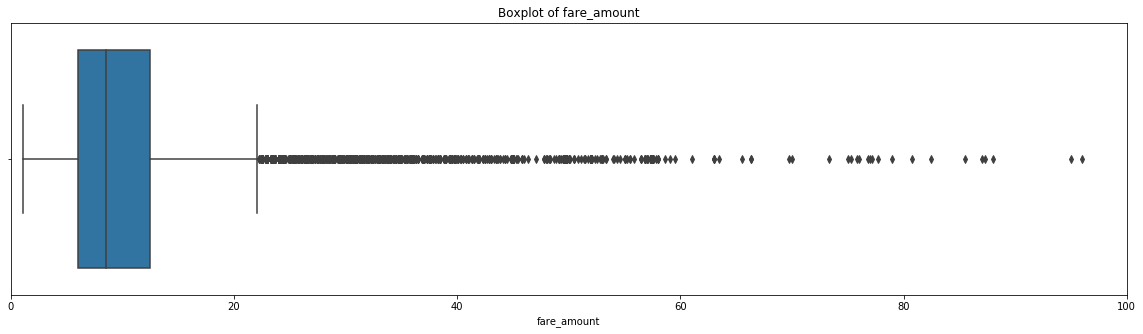

In [53]:
############################################## Outlier Analysis using Boxplot  #################################################
#We Will do Outlier Analysis only on Fare_amount just for now and we will do outlier analysis after feature engineering
#laitudes and longitudes. 
#Univariate Boxplots: Boxplots for all Numerical Variables including target variable.
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=train['fare_amount'],data=train,orient='h')
plt.title('Boxplot of fare_amount')
plt.savefig('bp of fare_amount.png')
plt.show()

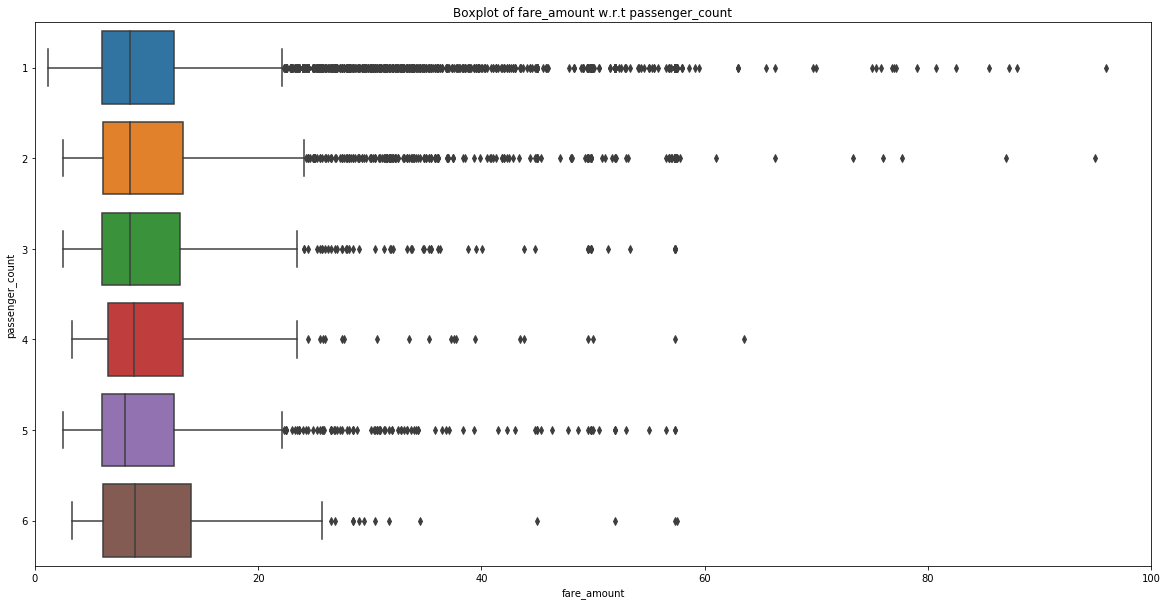

In [54]:
#Bivariate Boxplots: Boxplot for Numerical Variable Vs Categorical Variable.
plt.figure(figsize=(20,10))
plt.xlim(0,100)
_ = sns.boxplot(x=train['fare_amount'],y=train['passenger_count'],data=train,orient='h')
plt.title('Boxplot of fare_amount w.r.t passenger_count')
plt.savefig('Boxplot of fare_amount w.r.t passenger_count.png')
plt.show()

In [55]:
train['passenger_count'].describe()

count     15661
unique        6
top           1
freq      11056
Name: passenger_count, dtype: int64

In [56]:
#############################################  Outlier Treatment ##########################################################
#As we can see from the above Boxplots there are outliers in the train dataset.Reconsider pickup_longitude,etc.
def outlier_treatment(col):
    ''' calculating outlier indices and replacing them with NA  '''
    #Extract quartiles
    q75, q25 = np.percentile(train[col], [75 ,25])
    print(q75,q25)
    #Calculate IQR
    iqr = q75 - q25
    #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    print(minimum,maximum)
    #Replace with NA
    train.loc[train[col] < minimum,col] = np.nan
    train.loc[train[col] > maximum,col] = np.nan

In [57]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1


In [58]:
outlier_treatment('fare_amount')

12.5 6.0
-3.75 22.25


In [59]:
pd.DataFrame(train.isnull().sum())

,0
fare_amount,1359
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [60]:
train.std()

fare_amount          4.136102
pickup_longitude     2.659050
pickup_latitude      2.613305
dropoff_longitude    2.710835
dropoff_latitude     2.632400
passenger_count      1.264322
dtype: float64

In [61]:
#Imputing with missing values using KNN
train = pd.DataFrame(KNN(k = 3).fit_transform(train), columns = train.columns, index=train.index)

Imputing row 1/15661 with 0 missing, elapsed time: 60.298
Imputing row 101/15661 with 0 missing, elapsed time: 60.300
Imputing row 201/15661 with 0 missing, elapsed time: 60.302
Imputing row 301/15661 with 1 missing, elapsed time: 60.304
Imputing row 401/15661 with 0 missing, elapsed time: 60.306
Imputing row 501/15661 with 0 missing, elapsed time: 60.309
Imputing row 601/15661 with 1 missing, elapsed time: 60.311
Imputing row 701/15661 with 0 missing, elapsed time: 60.313
Imputing row 801/15661 with 0 missing, elapsed time: 60.316
Imputing row 901/15661 with 0 missing, elapsed time: 60.318
Imputing row 1001/15661 with 0 missing, elapsed time: 60.320
Imputing row 1101/15661 with 1 missing, elapsed time: 60.322
Imputing row 1201/15661 with 0 missing, elapsed time: 60.324
Imputing row 1301/15661 with 0 missing, elapsed time: 60.326
Imputing row 1401/15661 with 0 missing, elapsed time: 60.328
Imputing row 1501/15661 with 0 missing, elapsed time: 60.330
Imputing row 1601/15661 with 0 missi

Imputing row 15301/15661 with 0 missing, elapsed time: 60.666
Imputing row 15401/15661 with 0 missing, elapsed time: 60.671
Imputing row 15501/15661 with 0 missing, elapsed time: 60.673
Imputing row 15601/15661 with 0 missing, elapsed time: 60.676


In [62]:
train.std()

fare_amount          4.476970
pickup_longitude     2.659050
pickup_latitude      2.613305
dropoff_longitude    2.710835
dropoff_latitude     2.632400
passenger_count      1.264322
dtype: float64

In [63]:
train['passenger_count'].describe()

count    15661.000000
mean         1.649192
std          1.264322
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64

In [64]:
train['passenger_count']=train['passenger_count'].astype('int').round().astype('object').astype('category')

In [65]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,9.404603,-73.911514,40.689712,-73.906315,40.687655
std,4.476970,2.659050,2.613305,2.710835,2.632400
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992390,40.736530,-73.991369,40.736293
50%,8.200000,-73.982049,40.753300,-73.980555,40.754242
75%,11.800000,-73.968080,40.767805,-73.965360,40.768312
max,22.100000,40.766125,41.366138,40.802437,41.366138


In [66]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1


In [67]:
df2 = train.copy()
# train=df2.copy()

In [68]:
train.shape

(15661, 6)

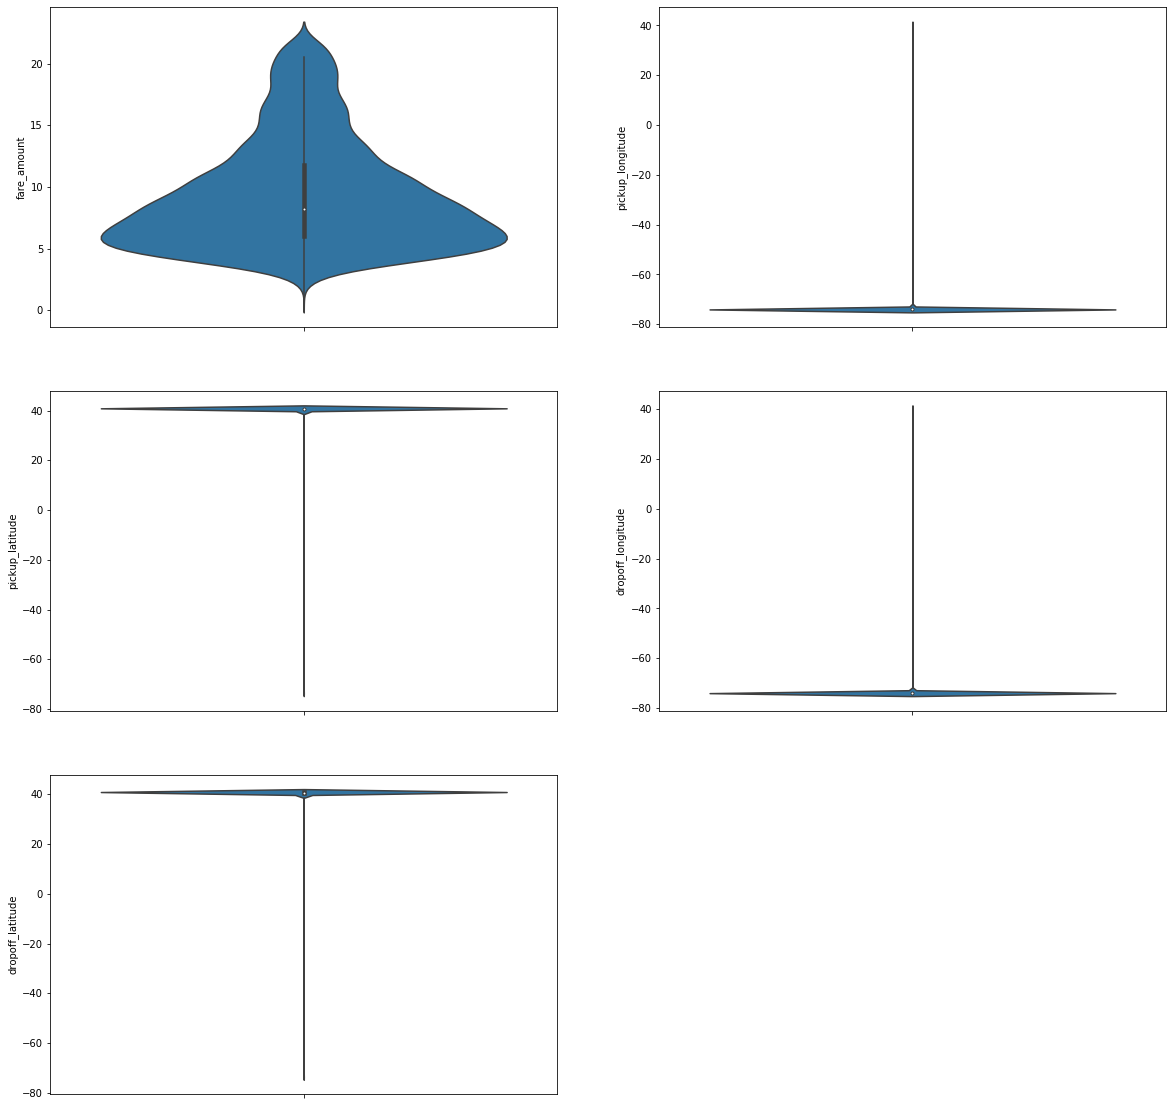

In [69]:
####################################  Graphical EDA - Data Visualization  ##################################################
# Some Violinplots to see spread of variables
plt.figure(figsize=(20,20))
plt.subplot(321)
_ = sns.violinplot(y='fare_amount',data=train)
plt.subplot(322)
_ = sns.violinplot(y='pickup_longitude',data=train)
plt.subplot(323)
_ = sns.violinplot(y='pickup_latitude',data=train)
plt.subplot(324)
_ = sns.violinplot(y='dropoff_longitude',data=train)
plt.subplot(325)
_ = sns.violinplot(y='dropoff_latitude',data=train)
plt.savefig('violin.png')
plt.show()

In [70]:
# Feature Engineering
#1.Feature Engineering for timestamp variable .we will derive new features from pickup_datetime variable
#new features will be year,month,day_of_week,hour

# we will Join 2 Dataframes pickup_datetime and train
train = pd.merge(pickup_datetime,train,right_index=True,left_index=True)
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1


In [71]:
train.shape

(15661, 7)

In [72]:
train=train.reset_index(drop=True)

In [73]:
# As we discussed in Missing value imputation step about dropping missing value, we will do it now.
pd.DataFrame(train.isna().sum())

,0
pickup_datetime,1
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [74]:
train=train.dropna()

In [75]:
data = [train,test]
for i in data:
    i["year"] = i["pickup_datetime"].apply(lambda row: row.year)
    i["month"] = i["pickup_datetime"].apply(lambda row: row.month)
#     i["day_of_month"] = i["pickup_datetime"].apply(lambda row: row.day)
    i["day_of_week"] = i["pickup_datetime"].apply(lambda row: row.dayofweek)
    i["hour"] = i["pickup_datetime"].apply(lambda row: row.hour)

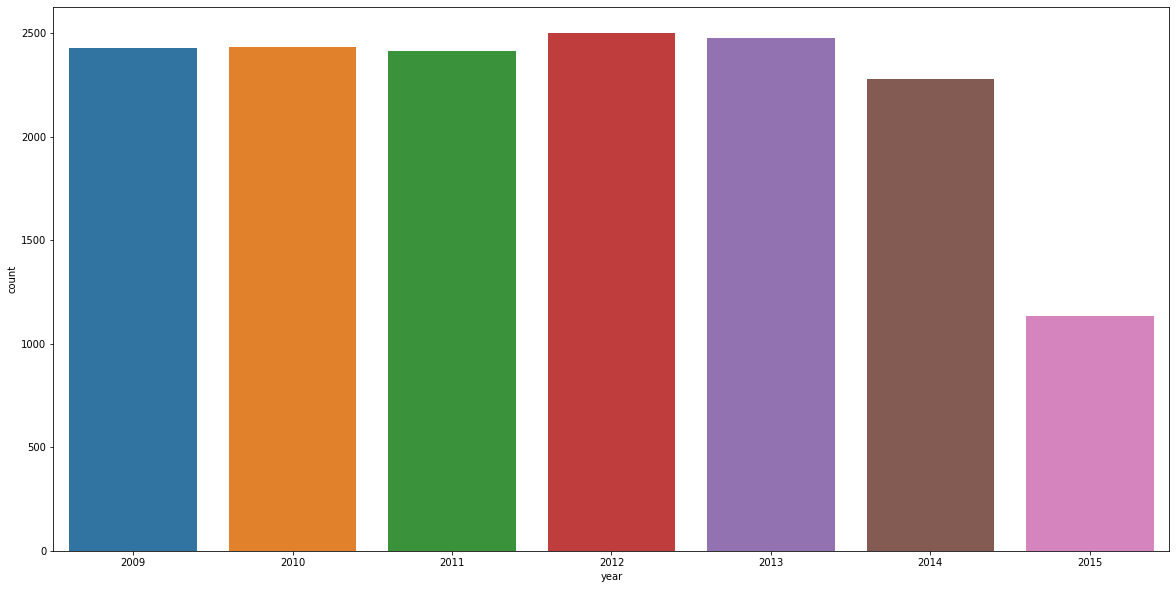

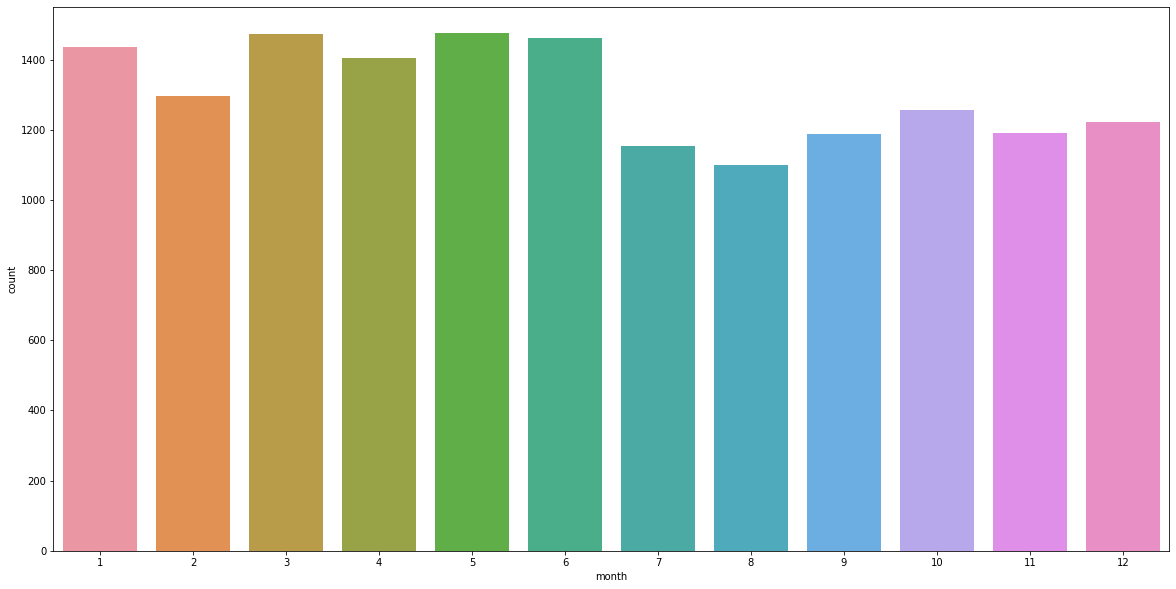

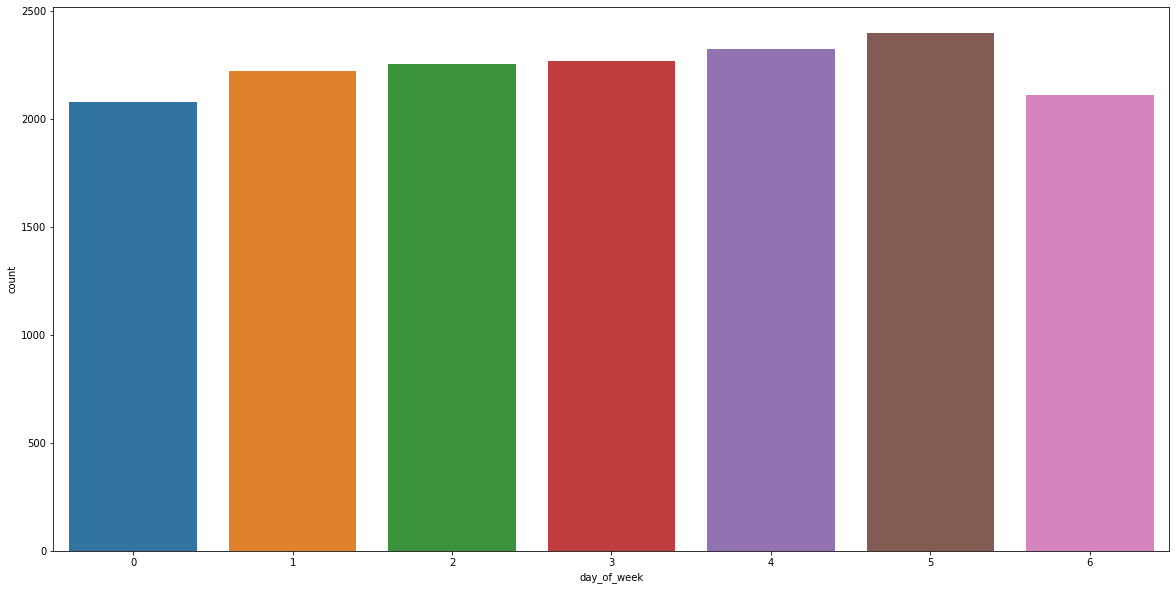

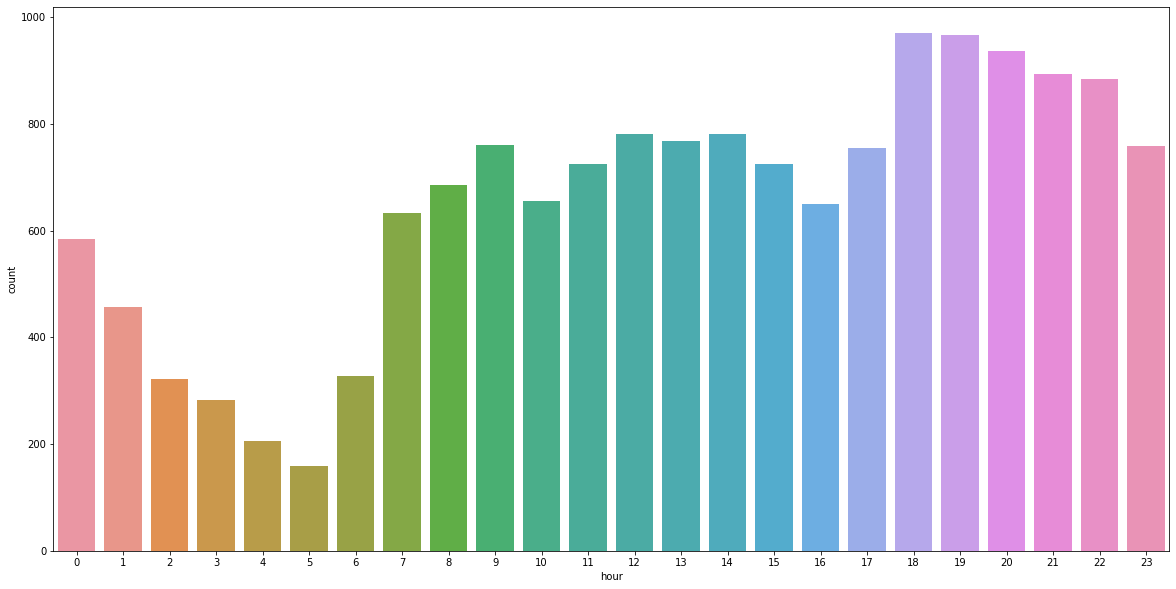

In [76]:
plt.figure(figsize=(20,10))
sns.countplot(train['year'])
plt.savefig('year.png')

plt.figure(figsize=(20,10))
sns.countplot(train['month'])
plt.savefig('month.png')

plt.figure(figsize=(20,10))
sns.countplot(train['day_of_week'])
plt.savefig('day_of_week.png')

plt.figure(figsize=(20,10))
sns.countplot(train['hour'])
plt.savefig('hour.png')

In [77]:
def f(x):
    ''' for sessions in a day using hour column '''
    if (x >=5) and (x <= 11):
        return 'morning'
    elif (x >=12) and (x <=16 ):
        return 'afternoon'
    elif (x >= 17) and (x <= 20):
        return'evening'
    elif (x >=21) and (x <= 23) :
        return 'night_PM'
    elif (x >=0) and (x <=4):
        return'night_AM'

In [78]:
def g(x):
    ''' for seasons in a year using month column'''
    if (x >=3) and (x <= 5):
        return 'spring'
    elif (x >=6) and (x <=8 ):
        return 'summer'
    elif (x >= 9) and (x <= 11):
        return'fall'
    elif (x >=12)|(x <= 2) :
        return 'winter'

In [79]:
def h(x):
    ''' for week:weekday/weekend in a day_of_week column '''
    if (x >=0) and (x <= 4):
        return 'weekday'
    elif (x >=5) and (x <=6 ):
        return 'weekend'

In [80]:
train['session'] = train['hour'].apply(f)
test['session'] = test['hour'].apply(f)

In [81]:
train['seasons'] = train['month'].apply(g)
test['seasons'] = test['month'].apply(g)

In [82]:
train['week'] = train['day_of_week'].apply(h)
test['week'] = test['day_of_week'].apply(h)

In [83]:
train.shape

(15660, 14)

In [84]:
test.shape

(9914, 13)

In [85]:
# Feature Engineering for passenger_count variable
# Because models in scikit learn require numerical input,if dataset contains categorical variables then we have to encode them.
# We will use one hot encoding technique for passenger_count variable.
train['passenger_count'].describe()

count     15660
unique        6
top           1
freq      11055
Name: passenger_count, dtype: int64

In [86]:
#Creating dummies for each variable in passenger_count and merging dummies dataframe to both train and test dataframe
temp = pd.get_dummies(train['passenger_count'], prefix = 'passenger_count')
train = train.join(temp)
temp = pd.get_dummies(test['passenger_count'], prefix = 'passenger_count')
test = test.join(temp)
temp = pd.get_dummies(train['seasons'], prefix = 'season')
train = train.join(temp)
temp = pd.get_dummies(test['seasons'], prefix = 'season')
test = test.join(temp)
temp = pd.get_dummies(train['week'], prefix = 'week')
train = train.join(temp)
temp = pd.get_dummies(test['week'], prefix = 'week')
test = test.join(temp)
temp = pd.get_dummies(train['session'], prefix = 'session')
train = train.join(temp)
temp = pd.get_dummies(test['session'], prefix = 'session')
test = test.join(temp)
temp = pd.get_dummies(train['year'], prefix = 'year')
train = train.join(temp)
temp = pd.get_dummies(test['year'], prefix = 'year')
test = test.join(temp)

In [87]:
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,...,session_morning,session_night_AM,session_night_PM,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,...,0,0,0,1,0,0,0,0,0,0
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,...,0,0,0,0,1,0,0,0,0,0
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,...,0,1,0,0,0,1,0,0,0,0
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,...,0,1,0,0,0,0,1,0,0,0
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,...,1,0,0,0,1,0,0,0,0,0


In [88]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,...,session_morning,session_night_AM,session_night_PM,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,...,0,0,0,0,0,0,0,0,0,1
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,...,0,0,0,0,0,0,0,0,0,1
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,...,1,0,0,0,0,1,0,0,0,0
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,...,0,0,1,0,0,0,1,0,0,0
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,...,0,0,1,0,0,0,1,0,0,0


In [89]:
train.columns

Index(['pickup_datetime', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'week_weekday', 'week_weekend', 'session_afternoon', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2009',
       'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014',
       'year_2015'],
      dtype='object')

In [90]:
# Feature Engineering for latitude and longitude variable
# As we have latitude and longitude data for pickup and dropoff,
# we will find the distance the cab travelled from pickup and dropoff location.

# Calculate distance the cab travelled from pickup and dropoff location using great_circle from geopy library
data = [train, test]
for i in data:
    i['great_circle']=i.apply(lambda x: great_circle((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],   x['dropoff_longitude'])).miles, axis=1)
    i['geodesic']=i.apply(lambda x: geodesic((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],   x['dropoff_longitude'])).miles, axis=1)

In [91]:
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,...,session_night_PM,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,great_circle,geodesic
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,...,0,1,0,0,0,0,0,0,0.640488,0.639764
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,...,0,0,1,0,0,0,0,0,5.250677,5.246511
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,...,0,0,0,1,0,0,0,0,0.863412,0.863167
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,...,0,0,0,0,1,0,0,0,1.739388,1.737223
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,...,0,0,1,0,0,0,0,0,1.242220,1.241710


In [92]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,...,session_night_PM,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,great_circle,geodesic
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,...,0,0,0,0,0,0,0,1,1.443609,1.442197
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,...,0,0,0,0,0,0,0,1,1.507047,1.506080
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,...,0,0,0,1,0,0,0,0,0.384398,0.384120
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,...,1,0,0,0,1,0,0,0,1.218531,1.217683
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,...,1,0,0,0,1,0,0,0,3.347519,3.344737


In [93]:
pd.DataFrame(train.isna().sum())

,0
pickup_datetime,0
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
year,0
month,0
day_of_week,0


In [94]:
pd.DataFrame(test.isna().sum())

,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
year,0
month,0
day_of_week,0
hour,0


In [95]:
# We will remove the variables which were used to feature engineer new variables
train=train.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week','great_circle'],axis=1)
test=test.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week','great_circle'],axis=1)

In [96]:
train.shape,test.shape

((15660, 26), (9914, 25))

In [97]:
train.columns

Index(['fare_amount', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'week_weekday', 'week_weekend', 'session_afternoon',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2009', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [98]:
test.columns

Index(['passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'week_weekday', 'week_weekend', 'session_afternoon', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2009',
       'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014',
       'year_2015', 'geodesic'],
      dtype='object')

In [99]:
train.head()

,fare_amount,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,season_fall,season_spring,season_summer,...,session_night_AM,session_night_PM,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,geodesic
0,4.5,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0.639764
1,16.9,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,5.246511
2,5.7,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0.863167
3,7.7,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1.737223
4,5.3,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1.241710


In [100]:
test.head()

,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,season_fall,season_spring,season_summer,season_winter,...,session_night_AM,session_night_PM,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,geodesic
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1.442197
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1.506080
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0.384120
3,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1.217683
4,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,3.344737


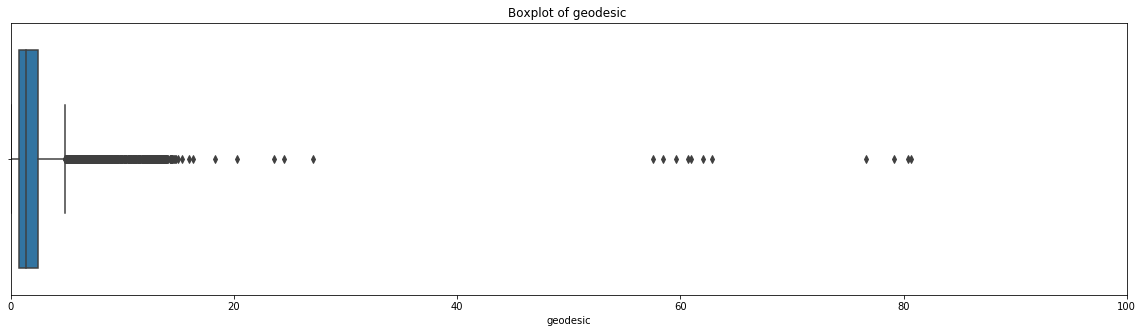

In [101]:
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=train['geodesic'],data=train,orient='h')
plt.title('Boxplot of geodesic ')
plt.savefig('bp geodesic.png')
plt.show()

In [102]:
outlier_treatment('geodesic')

2.425668049965582 0.7815214474966259
-1.6846984562068081 4.891887953669016


In [103]:
pd.DataFrame(train.isnull().sum())

,0
fare_amount,0
passenger_count_1,0
passenger_count_2,0
passenger_count_3,0
passenger_count_4,0
passenger_count_5,0
passenger_count_6,0
season_fall,0
season_spring,0
season_summer,0


In [104]:
#Imputing with missing values using KNN
train = pd.DataFrame(KNN(k = 3).fit_transform(train), columns = train.columns, index=train.index)

Imputing row 1/15660 with 0 missing, elapsed time: 107.375
Imputing row 101/15660 with 0 missing, elapsed time: 107.377
Imputing row 201/15660 with 0 missing, elapsed time: 107.380
Imputing row 301/15660 with 1 missing, elapsed time: 107.381
Imputing row 401/15660 with 0 missing, elapsed time: 107.383
Imputing row 501/15660 with 0 missing, elapsed time: 107.385
Imputing row 601/15660 with 1 missing, elapsed time: 107.387
Imputing row 701/15660 with 0 missing, elapsed time: 107.389
Imputing row 801/15660 with 0 missing, elapsed time: 107.392
Imputing row 901/15660 with 0 missing, elapsed time: 107.394
Imputing row 1001/15660 with 0 missing, elapsed time: 107.396
Imputing row 1101/15660 with 1 missing, elapsed time: 107.397
Imputing row 1201/15660 with 0 missing, elapsed time: 107.399
Imputing row 1301/15660 with 0 missing, elapsed time: 107.401
Imputing row 1401/15660 with 0 missing, elapsed time: 107.403
Imputing row 1501/15660 with 0 missing, elapsed time: 107.404
Imputing row 1601/15

Imputing row 15001/15660 with 1 missing, elapsed time: 107.746
Imputing row 15101/15660 with 0 missing, elapsed time: 107.748
Imputing row 15201/15660 with 0 missing, elapsed time: 107.750
Imputing row 15301/15660 with 0 missing, elapsed time: 107.751
Imputing row 15401/15660 with 0 missing, elapsed time: 107.754
Imputing row 15501/15660 with 1 missing, elapsed time: 107.756
Imputing row 15601/15660 with 0 missing, elapsed time: 107.758


In [105]:
# Correlation Analysis

#Statistically correlated: features move together directionally.
#Linear models assume feature independence.
#And if features are correlated that could introduce bias into our models.

cat_var=['passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'week_weekday', 'week_weekend', 'session_afternoon',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2009', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year_2015',]
num_var=['fare_amount','geodesic']
train[cat_var]=train[cat_var].apply(lambda x: x.astype('category') )
test[cat_var]=test[cat_var].apply(lambda x: x.astype('category') )

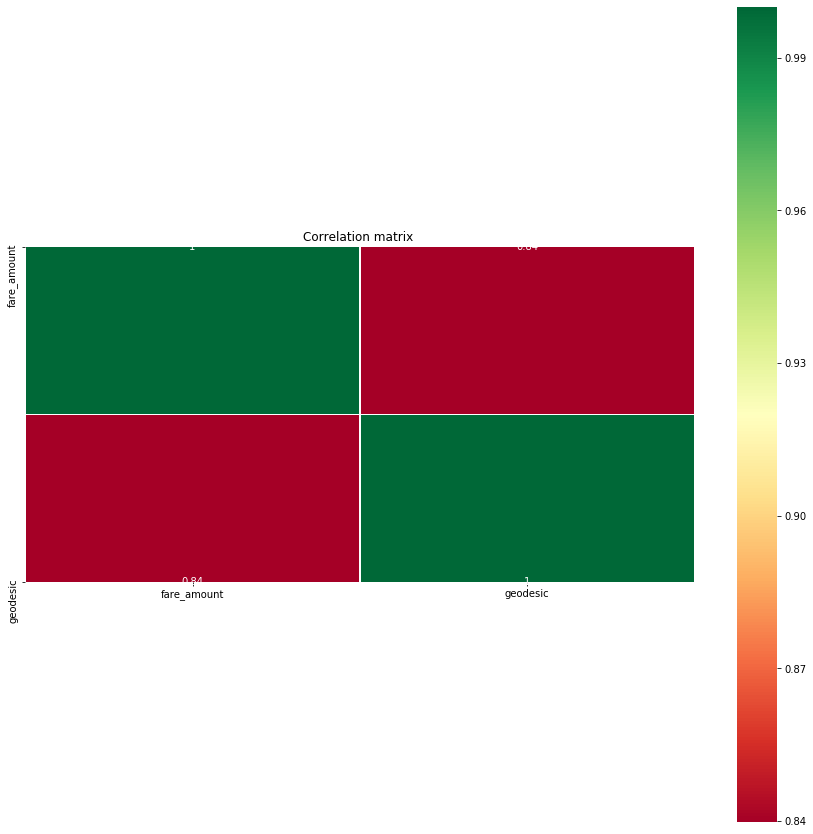

In [106]:
# We will plot a Heatmap of correlation whereas, correlation measures how strongly 2 quantities are related to each other.
# heatmap using correlation matrix
plt.figure(figsize=(15,15))
_ = sns.heatmap(train[num_var].corr(), square=True, cmap='RdYlGn',linewidths=0.5,linecolor='w',annot=True)
plt.title('Correlation matrix ')
plt.savefig('correlation.png')
plt.show()
#As we can see from above correlation plot fare_amount and geodesic is correlated to each other.

In [107]:
# Chi-square test of Independence for Categorical Variables/Features
# Hypothesis testing :
# Null Hypothesis: 2 variables are independent.
# Alternate Hypothesis: 2 variables are not independent.
# If p-value is less than 0.05 then we reject the null hypothesis saying that 2 variables are dependent.
# And if p-value is greater than 0.05 then we accept the null hypothesis saying that 2 variables are independent.
# There should be no dependencies between Independent variables.
# So we will remove that variable whose p-value with other variable is low than 0.05.
# And we will keep that variable whose p-value with other variable is high than 0.05

#loop for chi square values
for i in cat_var:
    for j in cat_var:
        if(i != j):
            chi2, p, dof, ex = chi2_contingency(pd.crosstab(train[i], train[j]))
            if(p < 0.05):
                print(i,"and",j,"are dependent on each other with",p,'----Remove')
            else:
                print(i,"and",j,"are independent on each other with",p,'----Keep')

passenger_count_1 and passenger_count_2 are dependent on each other with 0.0 ----Remove
passenger_count_1 and passenger_count_3 are dependent on each other with 0.0 ----Remove
passenger_count_1 and passenger_count_4 are dependent on each other with 8.202717166738717e-172 ----Remove
passenger_count_1 and passenger_count_5 are dependent on each other with 0.0 ----Remove
passenger_count_1 and passenger_count_6 are dependent on each other with 8.874469154933326e-159 ----Remove
passenger_count_1 and season_fall are independent on each other with 0.09177348828999972 ----Keep
passenger_count_1 and season_spring are independent on each other with 0.19459322658354578 ----Keep
passenger_count_1 and season_summer are independent on each other with 0.5655191763723804 ----Keep
passenger_count_1 and season_winter are independent on each other with 0.7934080374609872 ----Keep
passenger_count_1 and week_weekday are dependent on each other with 1.2973002145560315e-17 ----Remove
passenger_count_1 and we

passenger_count_4 and session_night_PM are independent on each other with 0.3839396343139284 ----Keep
passenger_count_4 and year_2009 are independent on each other with 0.8594724411616982 ----Keep
passenger_count_4 and year_2010 are independent on each other with 0.4177701247421539 ----Keep
passenger_count_4 and year_2011 are independent on each other with 0.2605096261576615 ----Keep
passenger_count_4 and year_2012 are independent on each other with 0.8273401138397842 ----Keep
passenger_count_4 and year_2013 are independent on each other with 0.7503872938113446 ----Keep
passenger_count_4 and year_2014 are independent on each other with 0.8639726181048024 ----Keep
passenger_count_4 and year_2015 are independent on each other with 0.7688374550240342 ----Keep
passenger_count_5 and passenger_count_1 are dependent on each other with 0.0 ----Remove
passenger_count_5 and passenger_count_2 are dependent on each other with 1.02944814727332e-42 ----Remove
passenger_count_5 and passenger_count_3 

season_spring and season_winter are dependent on each other with 0.0 ----Remove
season_spring and week_weekday are independent on each other with 0.7961003257905971 ----Keep
season_spring and week_weekend are independent on each other with 0.7961003257905971 ----Keep
season_spring and session_afternoon are dependent on each other with 0.029003107973059612 ----Remove
season_spring and session_evening are independent on each other with 0.814055875892082 ----Keep
season_spring and session_morning are independent on each other with 0.056579031369672135 ----Keep
season_spring and session_night_AM are independent on each other with 0.5918306289650044 ----Keep
season_spring and session_night_PM are independent on each other with 0.6544364941549473 ----Keep
season_spring and year_2009 are dependent on each other with 0.030189264921420895 ----Remove
season_spring and year_2010 are independent on each other with 0.221419448827001 ----Keep
season_spring and year_2011 are independent on each other

week_weekend and season_summer are dependent on each other with 0.012558478987137396 ----Remove
week_weekend and season_winter are independent on each other with 0.39970476035174074 ----Keep
week_weekend and week_weekday are dependent on each other with 0.0 ----Remove
week_weekend and session_afternoon are independent on each other with 0.25196776638736873 ----Keep
week_weekend and session_evening are dependent on each other with 3.3534430478007226e-06 ----Remove
week_weekend and session_morning are dependent on each other with 1.5044462337151303e-38 ----Remove
week_weekend and session_night_AM are dependent on each other with 7.159787243250608e-127 ----Remove
week_weekend and session_night_PM are independent on each other with 0.09651660555625668 ----Keep
week_weekend and year_2009 are dependent on each other with 0.046245505249422496 ----Remove
week_weekend and year_2010 are independent on each other with 0.24720655609127565 ----Keep
week_weekend and year_2011 are independent on each

session_night_AM and passenger_count_6 are independent on each other with 0.7921431118695867 ----Keep
session_night_AM and season_fall are independent on each other with 0.5850053551743142 ----Keep
session_night_AM and season_spring are independent on each other with 0.5918306289650044 ----Keep
session_night_AM and season_summer are dependent on each other with 0.04867734538089146 ----Remove
session_night_AM and season_winter are independent on each other with 0.056412724456896914 ----Keep
session_night_AM and week_weekday are dependent on each other with 7.159787243250608e-127 ----Remove
session_night_AM and week_weekend are dependent on each other with 7.159787243250608e-127 ----Remove
session_night_AM and session_afternoon are dependent on each other with 7.540755298163959e-143 ----Remove
session_night_AM and session_evening are dependent on each other with 3.5312348605341994e-139 ----Remove
session_night_AM and session_morning are dependent on each other with 3.155991736009208e-155

year_2011 and passenger_count_1 are dependent on each other with 0.04677008972656723 ----Remove
year_2011 and passenger_count_2 are dependent on each other with 0.014898552448686538 ----Remove
year_2011 and passenger_count_3 are independent on each other with 0.7134762468059598 ----Keep
year_2011 and passenger_count_4 are independent on each other with 0.2605096261576615 ----Keep
year_2011 and passenger_count_5 are independent on each other with 0.13831321134083152 ----Keep
year_2011 and passenger_count_6 are dependent on each other with 2.197731275140237e-05 ----Remove
year_2011 and season_fall are independent on each other with 0.0563851649509292 ----Keep
year_2011 and season_spring are independent on each other with 0.07907867810922532 ----Keep
year_2011 and season_summer are independent on each other with 0.5300696076494669 ----Keep
year_2011 and season_winter are independent on each other with 0.5106272582893163 ----Keep
year_2011 and week_weekday are independent on each other wit

year_2014 and year_2015 are dependent on each other with 6.999621469846093e-47 ----Remove
year_2015 and passenger_count_1 are independent on each other with 0.928332656041697 ----Keep
year_2015 and passenger_count_2 are independent on each other with 0.6616706193591912 ----Keep
year_2015 and passenger_count_3 are independent on each other with 0.698110950996621 ----Keep
year_2015 and passenger_count_4 are independent on each other with 0.7688374550240342 ----Keep
year_2015 and passenger_count_5 are dependent on each other with 0.00021649439325125124 ----Remove
year_2015 and passenger_count_6 are dependent on each other with 1.7897257145001053e-06 ----Remove
year_2015 and season_fall are dependent on each other with 5.638083480001399e-82 ----Remove
year_2015 and season_spring are dependent on each other with 2.8816680248288835e-70 ----Remove
year_2015 and season_summer are dependent on each other with 2.097528790450738e-08 ----Remove
year_2015 and season_winter are dependent on each oth

In [108]:
train.columns

Index(['fare_amount', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'week_weekday', 'week_weekend', 'session_afternoon',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2009', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [109]:
# Analysis of Variance(Anova) Test
# It is carried out to compare between each groups in a categorical variable.
# ANOVA only lets us know the means for different groups are same or not. It doesn’t help us identify which mean is different.
# Hypothesis testing :
# Null Hypothesis: mean of all categories in a variable are same.
# Alternate Hypothesis: mean of at least one category in a variable is different.
# If p-value is less than 0.05 then we reject the null hypothesis.
# And if p-value is greater than 0.05 then we accept the null hypothesis.
model = ols('fare_amount ~ C(passenger_count_2)+C(passenger_count_3)+C(passenger_count_4)+C(passenger_count_5)+C(passenger_count_6)+C(season_spring)+C(season_summer)+C(season_winter)+C(week_weekend)+C(session_night_AM)+C(session_night_PM)+C(session_evening)+C(session_morning)+C(year_2010)+C(year_2011)+C(year_2012)+C(year_2013)+C(year_2014)+C(year_2015)',data=train).fit()
                
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(passenger_count_2),1.0,10.568728,10.568728,0.545736,4.600765e-01
C(passenger_count_3),1.0,17.059092,17.059092,0.880877,3.479760e-01
C(passenger_count_4),1.0,63.933288,63.933288,3.301312,6.924368e-02
C(passenger_count_5),1.0,21.286924,21.286924,1.099189,2.944603e-01
C(passenger_count_6),1.0,145.816804,145.816804,7.529518,6.076534e-03
C(season_spring),1.0,28.945378,28.945378,1.494648,2.215152e-01
C(season_summer),1.0,26.849975,26.849975,1.386448,2.390238e-01
C(season_winter),1.0,481.677256,481.677256,24.872287,6.191324e-07
C(week_weekend),1.0,130.826572,130.826572,6.755470,9.354849e-03
C(session_night_AM),1.0,2130.002751,2130.002751,109.986594,1.200118e-25


In [110]:
# Every variable has p-value less than 0.05 therefore we reject the null hypothesis.

In [111]:

#########################################  Multicollinearity Test ##############################################################
# VIF is always greater or equal to 1.
# if VIF is 1 --- Not correlated to any of the variables.
# if VIF is between 1-5 --- Moderately correlated.
# if VIF is above 5 --- Highly correlated.
# If there are multiple variables with VIF greater than 5, only remove the variable with the highest VIF.

outcome, predictors = dmatrices('fare_amount ~ geodesic+passenger_count_2+passenger_count_3+passenger_count_4+passenger_count_5+passenger_count_6+season_spring+season_summer+season_winter+week_weekend+session_night_AM+session_night_PM+session_evening+session_morning+year_2010+year_2011+year_2012+year_2013+year_2014+year_2015',train, return_type='dataframe')
# calculating VIF for each individual Predictors
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif

,VIF,features
0,15.269760,Intercept
1,1.040699,passenger_count_2[T.1.0]
2,1.019514,passenger_count_3[T.1.0]
3,1.011860,passenger_count_4[T.1.0]
4,1.024990,passenger_count_5[T.1.0]
5,1.017215,passenger_count_6[T.1.0]
6,1.642257,season_spring[T.1.0]
7,1.552391,season_summer[T.1.0]
8,1.587603,season_winter[T.1.0]
9,1.050861,week_weekend[T.1.0]


In [112]:
#So we have no or very low multicollinearity

In [113]:
#Feature Scaling Check with or without normalization of standarscalar
train[num_var].var()

fare_amount    20.044259
geodesic        1.227934
dtype: float64

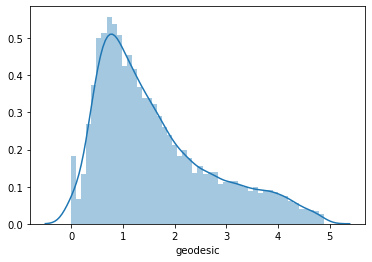

In [114]:
sns.distplot(train['geodesic'],bins=50)
plt.savefig('distplot.png')

In [115]:
#Normalization
train['geodesic'] = (train['geodesic'] - min(train['geodesic']))/(max(train['geodesic']) - min(train['geodesic']))
test['geodesic'] = (test['geodesic'] - min(test['geodesic']))/(max(test['geodesic']) - min(test['geodesic']))

In [116]:
train['geodesic'].var()

0.05137824550477928

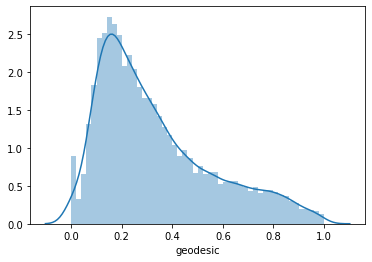

In [117]:
sns.distplot(train['geodesic'],bins=50)
plt.savefig('distplot.png')

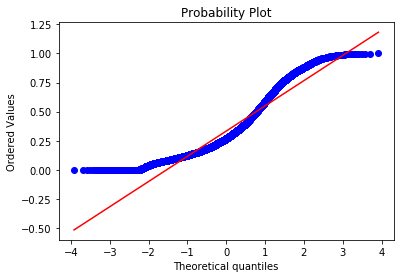

In [118]:
plt.figure()
stats.probplot(train['geodesic'], dist='norm', fit=True,plot=plt)
plt.savefig('qq prob plot1.png')

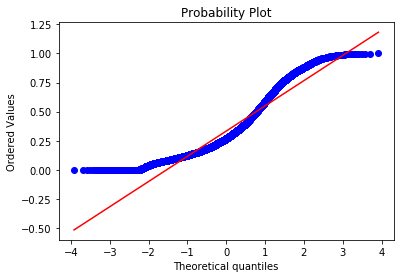

In [119]:
plt.figure()
stats.probplot(train['geodesic'], dist='norm', fit=True,plot=plt)
plt.savefig('qq prob plot2.png')

In [120]:
train.columns

Index(['fare_amount', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'week_weekday', 'week_weekend', 'session_afternoon',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2009', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [121]:
#Splitting train into train and validation subsets
#X_train y_train--are train subset
#X_test y_test--are validation subset

X = train.drop('fare_amount',axis=1).values
y = train['fare_amount'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
print(train.shape, X_train.shape, X_test.shape,y_train.shape,y_test.shape)

(15660, 26) (11745, 25) (3915, 25) (11745,) (3915,)


In [122]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def scores(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_))) 
def test_scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X_train)
    scores(y_train,y_pred)
    print('RMSLE:',rmsle(y_train,y_pred))
    print()
    print('<<<------------------- Test Data Score --------------------->')
    print()
    # Evaluating on Test Set
    y_pred = model.predict(X_test)
    scores(y_test,y_pred)
    print('RMSLE:',rmsle(y_test,y_pred))#

R^2: 0.7376225260714823
Root Mean Squared Error: 2.3194277899855202
<<<------------------- Training Data Score --------------------->

r square   0.7318940678707687
Adjusted r square:0.7313221207504316
MAPE:18.787536821618957
MSE: 5.332410562482569
RMSE: 2.309201282366388
RMSLE: 0.2169724849418544

<<<------------------- Test Data Score --------------------->

r square   0.7376225260714823
Adjusted r square:0.7359358619294887
MAPE:19.03520662994582
MSE: 5.379745272957115
RMSE: 2.3194277899855202
RMSLE: 0.21619763195611283
[-2.00944007e+12 -2.00944007e+12 -2.00944007e+12 -2.00944007e+12
 -2.00944007e+12 -2.00944007e+12  4.58409296e+12  4.58409296e+12
  4.58409296e+12  4.58409296e+12 -1.53468075e+11 -1.53468075e+11
 -1.77552992e+12 -1.77552992e+12 -1.77552992e+12 -1.77552992e+12
 -1.77552992e+12  1.44135224e+13  1.44135224e+13  1.44135224e+13
  1.44135224e+13  1.44135224e+13  1.44135224e+13  1.44135224e+13
  1.67393153e+01]


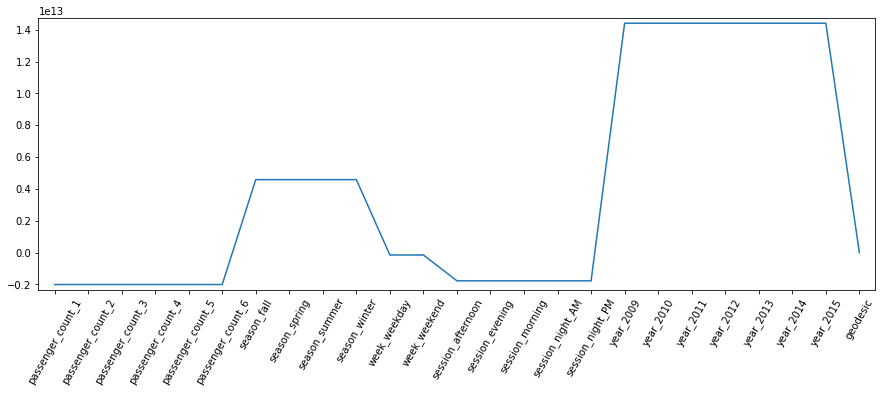

In [123]:
########################################## Multiple Linear Regression ####################################################
# Create the regressor: reg_all
reg_all = LinearRegression(copy_X= True, fit_intercept=True)

# Fit the regressor to the training data
reg_all.fit(X_train,y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))
test_scores(reg_all)

# Compute and print the coefficients
reg_coef = reg_all.coef_
print(reg_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.plot(range(len(test.columns)), reg_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
plt.savefig('linear coefficients')
plt.show()

In [124]:
from sklearn.model_selection import cross_val_score
# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg,X,y,cv=5,scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-5.36353688 -5.40351131 -5.16289764 -5.34366737 -5.50896489]
Average 5-Fold CV Score: -5.356515617327419


In [125]:
############################################ Ridge Regression #########################################################
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(500,5000,500)}
# Instantiate a Decision ridge classifier: ridge
ridge = Ridge()

# Instantiate the gridSearchCV object: ridge_cv
ridge_cv = GridSearchCV(ridge, param_dist, cv=5,scoring='r2')

# Fit it to the data
ridge_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision ridge Parameters: {}".format(ridge_cv.best_params_))
print("Best score is {}".format(ridge_cv.best_score_))

Tuned Decision ridge Parameters: {'alpha': 0.0004498432668969444, 'max_iter': 500, 'normalize': True}
Best score is 0.732485216428362


[-0.06531092 -0.0477062   0.09843548  0.12999391  0.167395    0.12844017
  0.34610094 -0.10517989 -0.10024159 -0.12303822  0.10843735 -0.10843735
  0.43362179  0.02898756 -0.03124319 -0.26614426 -0.36828086 -0.63006584
 -0.68213421 -0.60471602 -0.17246602  0.66587858  0.88898253  1.1196266
 16.73261271]


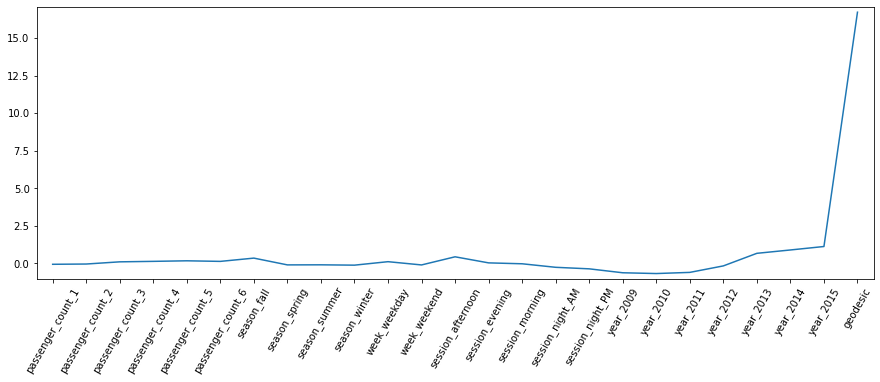

<<<------------------- Training Data Score --------------------->

r square   0.7319161131384909
Adjusted r square:0.731344213047055
MAPE:18.80124138732529
MSE: 5.331972099903539
RMSE: 2.309106342268268
RMSLE: 0.21707688009459786

<<<------------------- Test Data Score --------------------->

r square   0.7374451895020702
Adjusted r square:0.7357573853718444
MAPE:19.05298124082875
MSE: 5.383381353283421
RMSE: 2.320211488912901
RMSLE: 0.2163840457982791


In [126]:
ridge = Ridge(alpha=0.0004498432668969444, normalize=True,max_iter = 500)

# Fit the regressor to the data
ridge.fit(X_train,y_train)

# Compute and print the coefficients
ridge_coef = ridge.coef_
print(ridge_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.plot(range(len(test.columns)), ridge_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
plt.savefig('ridge coefficients')
plt.show()
test_scores(ridge)

In [127]:
############################################  Lasso Regression ##########################################################
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(500,5000,500)}
# Instantiate a Decision lasso classifier: lasso
lasso = Lasso()

# Instantiate the gridSearchCV object: lasso_cv
lasso_cv = GridSearchCV(lasso, param_dist, cv=5,scoring='r2')

# Fit it to the data
lasso_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision lasso Parameters: {}".format(lasso_cv.best_params_))
print("Best score is {}".format(lasso_cv.best_score_))

Tuned Decision lasso Parameters: {'alpha': 0.0011513953993264468, 'max_iter': 500, 'normalize': False}
Best score is 0.732519633822799


[-9.30907301e-02 -8.24581882e-02  0.00000000e+00 -0.00000000e+00
  1.18993190e-02  0.00000000e+00  3.92973371e-01  7.95410098e-03
 -0.00000000e+00 -2.57487283e-02  1.91840014e-01 -1.19503788e-16
  4.67400208e-01  1.04620404e-01 -0.00000000e+00 -2.15259343e-01
 -2.79147185e-01 -4.87773199e-01 -5.10291148e-01 -4.81509151e-01
 -0.00000000e+00  8.28482904e-01  1.02054960e+00  1.27146285e+00
  1.66937694e+01]


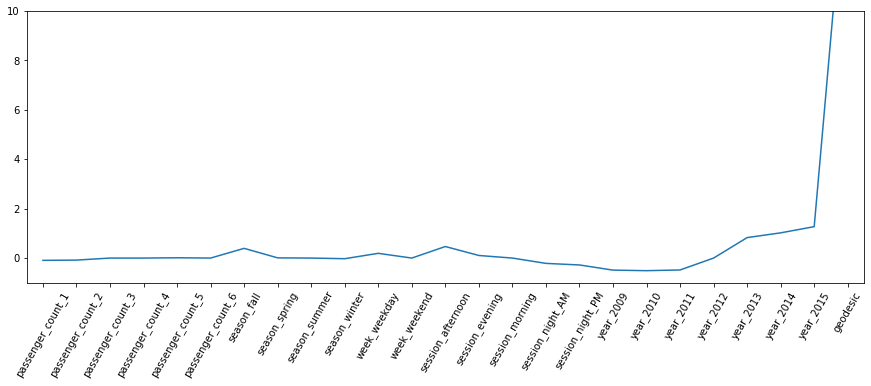

<<<------------------- Training Data Score --------------------->

r square   0.7317591341360833
Adjusted r square:0.7311868991632531
MAPE:18.831519808168213
MSE: 5.3350942855406815
RMSE: 2.309782302629553
RMSLE: 0.21698602570666214

<<<------------------- Test Data Score --------------------->

r square   0.7383550509169782
Adjusted r square:0.7366730957287355
MAPE:19.058148115378568
MSE: 5.364725702047023
RMSE: 2.316187751899017
RMSLE: 0.2159295104300361


In [128]:
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.0011513953993264468, normalize=False,max_iter = 500)

# Fit the regressor to the data
lasso.fit(X,y)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.ylim(-1,10)
plt.plot(range(len(test.columns)), lasso_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
plt.savefig('lasso coefficients')
plt.show()
test_scores(lasso)

In [129]:
###########################################    Decision Tree Regression   ###################################################
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15660 entries, 0 to 15660
Data columns (total 26 columns):
fare_amount          15660 non-null float64
passenger_count_1    15660 non-null category
passenger_count_2    15660 non-null category
passenger_count_3    15660 non-null category
passenger_count_4    15660 non-null category
passenger_count_5    15660 non-null category
passenger_count_6    15660 non-null category
season_fall          15660 non-null category
season_spring        15660 non-null category
season_summer        15660 non-null category
season_winter        15660 non-null category
week_weekday         15660 non-null category
week_weekend         15660 non-null category
session_afternoon    15660 non-null category
session_evening      15660 non-null category
session_morning      15660 non-null category
session_night_AM     15660 non-null category
session_night_PM     15660 non-null category
year_2009            15660 non-null category
year_2010            15660 non-null c

In [130]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': range(2,16,2),
              'min_samples_split': range(2,16,2)}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the gridSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 6, 'min_samples_split': 2}
Best score is 0.7287411728769153


[4.03221620e-04 5.95013592e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.26378084e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50502229e-04
 2.23311355e-03 4.13253005e-04 3.39922928e-04 0.00000000e+00
 4.20962862e-04 0.00000000e+00 8.45810793e-04 7.96630771e-04
 0.00000000e+00 1.14003303e-02 1.15637911e-02 8.69535620e-03
 9.61615713e-01]


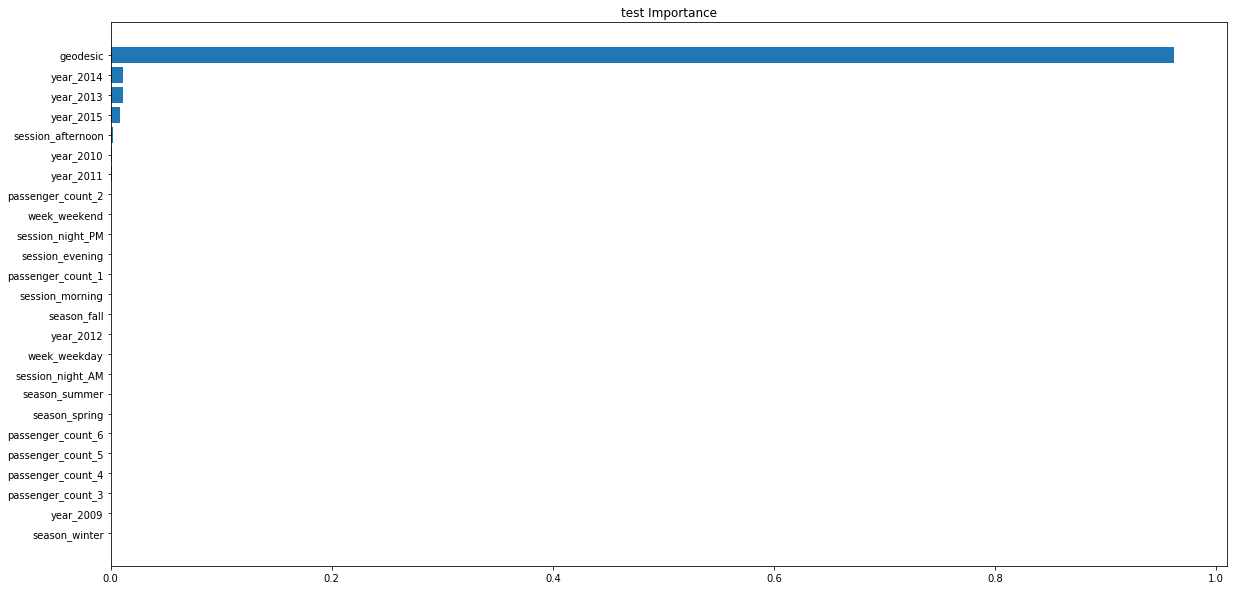

<<<------------------- Training Data Score --------------------->

r square   0.7450560196713882
Adjusted r square:0.7445121507825568
MAPE:18.58351069644048
MSE: 5.070629966107403
RMSE: 2.251805934379649
RMSLE: 0.20906442202720074

<<<------------------- Test Data Score --------------------->

r square   0.7368581751576098
Adjusted r square:0.7351665974715569
MAPE:19.157675240672827
MSE: 5.395417400423767
RMSE: 2.3228037800089285
RMSLE: 0.21304896818992566


In [131]:
# Instantiate a tree regressor: tree
tree = DecisionTreeRegressor(max_depth= 6, min_samples_split=2)

# Fit the regressor to the data
tree.fit(X_train,y_train)

# Compute and print the coefficients
tree_features = tree.feature_importances_
print(tree_features)

# Sort test importances in descending order
indices = np.argsort(tree_features)[::1]

# Rearrange test names so they match the sorted test importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("test Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),tree_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig('tree test importance')
plt.show()
# Make predictions and cal error
test_scores(tree)

In [132]:
##########################################  Random Forest Regression  ###############################################
# Create the random grid
random_grid = {'n_estimators': range(100,500,100),
               'max_depth': range(5,20,1),
               'min_samples_leaf':range(2,5,1),
              'max_features':['auto','sqrt','log2'],
              'bootstrap': [True, False],
              'min_samples_split': range(2,5,1)}
# Instantiate a Decision Forest classifier: Forest
Forest = RandomForestRegressor()

# Instantiate the gridSearchCV object: Forest_cv
Forest_cv = RandomizedSearchCV(Forest, random_grid, cv=5)

# Fit it to the data
Forest_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(Forest_cv.best_params_))
print("Best score is {}".format(Forest_cv.best_score_))

Tuned Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 13, 'bootstrap': True}
Best score is 0.7423876283274332


[2.12988190e-03 1.38061856e-03 8.39892587e-04 5.81801483e-04
 6.84151584e-04 2.84055748e-04 4.69989439e-03 1.78122783e-03
 2.02767708e-03 1.92281186e-03 1.59333221e-03 1.67717485e-03
 5.97456163e-03 2.18136588e-03 1.97986824e-03 1.82457772e-03
 2.93248632e-03 1.81366758e-03 3.15201933e-03 1.48294415e-03
 2.35514294e-03 9.62886405e-03 1.14909141e-02 8.84254981e-03
 9.26738518e-01]


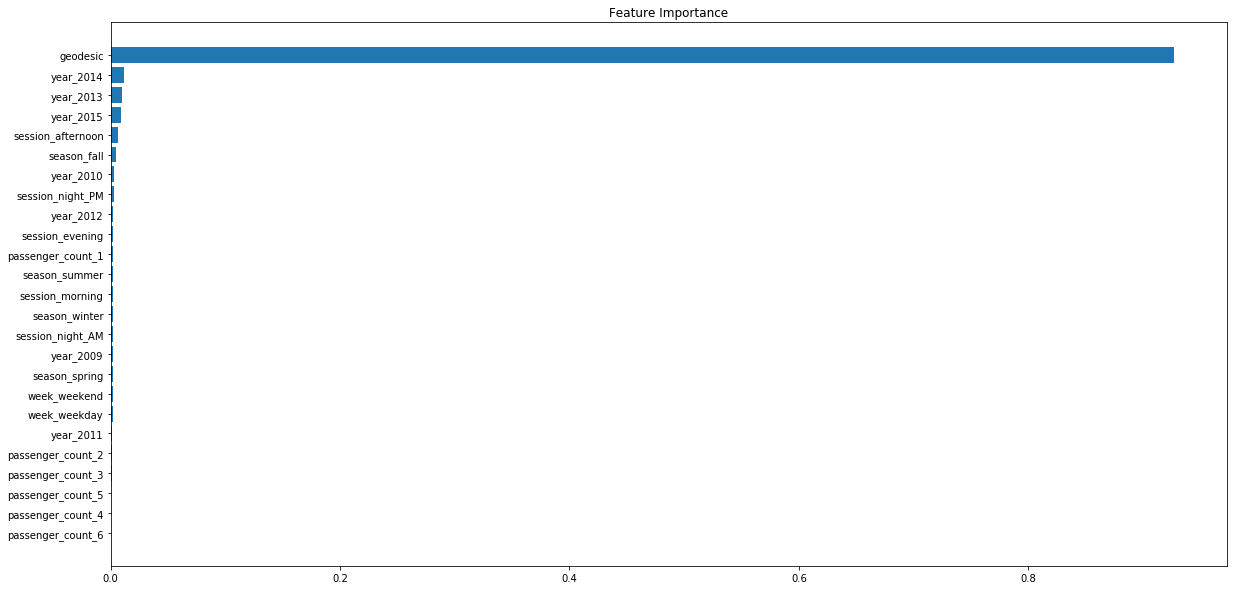

<<<------------------- Training Data Score --------------------->

r square   0.7957972011262027
Adjusted r square:0.7953615777819032
MAPE:16.72946183721898
MSE: 4.061428827610859
RMSE: 2.0152986943902036
RMSLE: 0.18859905010555217

<<<------------------- Test Data Score --------------------->

r square   0.7529818387809495
Adjusted r square:0.7513939102567848
MAPE:18.46057752030303
MSE: 5.064820410287168
RMSE: 2.250515587657008
RMSLE: 0.20645656273636886


In [133]:
# Instantiate a Forest regressor: Forest
Forest = RandomForestRegressor(n_estimators=100, min_samples_split= 2, min_samples_leaf=4, max_features='auto', max_depth=9, bootstrap=True)

# Fit the regressor to the data
Forest.fit(X_train,y_train)

# Compute and print the coefficients
Forest_features = Forest.feature_importances_
print(Forest_features)

# Sort feature importances in descending order
indices = np.argsort(Forest_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance1")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),Forest_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig('Random forest feature importance')
plt.show()# Make predictions
test_scores(Forest)

In [134]:
from sklearn.model_selection import cross_val_score
# Create a random forest regression object: Forest
Forest = RandomForestRegressor(n_estimators=400, min_samples_split= 2, min_samples_leaf=4, max_features='auto', max_depth=12, bootstrap=True)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(Forest,X,y,cv=5,scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-5.1113495  -5.09286622 -5.04831669 -5.11356383 -5.15293999]
Average 5-Fold CV Score: -5.103807246546199


In [135]:
# Improving accuracy using XGBOOST
# Improve Accuracy a) Algorithm Tuning b) Ensembles
data_dmatrix = xgb.DMatrix(data=X,label=y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [136]:
dtrain,dtest,data_dmatrix

(<xgboost.core.DMatrix at 0xcd0ae23548>,
 <xgboost.core.DMatrix at 0xcd0ae231c8>)

In [137]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()

[09:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,9.031745,0.018690,9.032518,0.077845
1,8.300922,0.049114,8.302694,0.106766
2,7.657224,0.099476,7.659598,0.146379
3,7.090697,0.148611,7.093888,0.189378
4,6.549450,0.144432,6.553669,0.192497


In [138]:
# the final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

49    2.37069
Name: test-rmse-mean, dtype: float64


In [139]:
Xgb = XGBRegressor()
Xgb.fit(X_train,y_train)
# pred_xgb = model_xgb.predict(X_test)
test_scores(Xgb)

[09:22:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<<<------------------- Training Data Score --------------------->

r square   0.7614934465500416
Adjusted r square:0.760984643423815
MAPE:17.732954041750066
MSE: 4.743702814545845
RMSE: 2.1780043192211176
RMSLE: 0.20054030997210284

<<<------------------- Test Data Score --------------------->

r square   0.7578688501955203
Adjusted r square:0.7563123372757178
MAPE:18.13195356047816
MSE: 4.96461791895749
RMSE: 2.2281422573429843
RMSLE: 0.20396692547702722


In [140]:
# Create the random grid
para = {'n_estimators': range(100,500,100),
               'max_depth': range(3,10,1),
        'reg_alpha':np.logspace(-4, 0, 50),
        'subsample': np.arange(0.1,1,0.2),
        'colsample_bytree': np.arange(0.1,1,0.2),
        'colsample_bylevel': np.arange(0.1,1,0.2),
        'colsample_bynode': np.arange(0.1,1,0.2),
       'learning_rate': np.arange(.05, 1, .05)}
# Instantiate a Decision Forest classifier: Forest
Xgb = XGBRegressor()

# Instantiate the gridSearchCV object: Forest_cv
xgb_cv = RandomizedSearchCV(Xgb, para, cv=5)

# Fit it to the data
xgb_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Xgboost Parameters: {}".format(xgb_cv.best_params_))
print("Best score is {}".format(xgb_cv.best_score_))

[09:22:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:23:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:23:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:23:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:23:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:23:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:23:14] WARNI

[09:27:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tuned Xgboost Parameters: {'subsample': 0.1, 'reg_alpha': 0.08685113737513521, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7000000000000001, 'colsample_bynode': 0.7000000000000001, 'colsample_bylevel': 0.9000000000000001}
Best score is 0.7476294983965251


[09:27:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.01999236 0.01994434 0.01597788 0.01645083 0.01483588 0.02188248
 0.0238892  0.01990279 0.01957816 0.01897927 0.01840858 0.02113209
 0.02350281 0.02219312 0.01846749 0.03074547 0.02541358 0.037622
 0.02741274 0.02837672 0.02019275 0.0433383  0.04164499 0.04373294
 0.40638325]


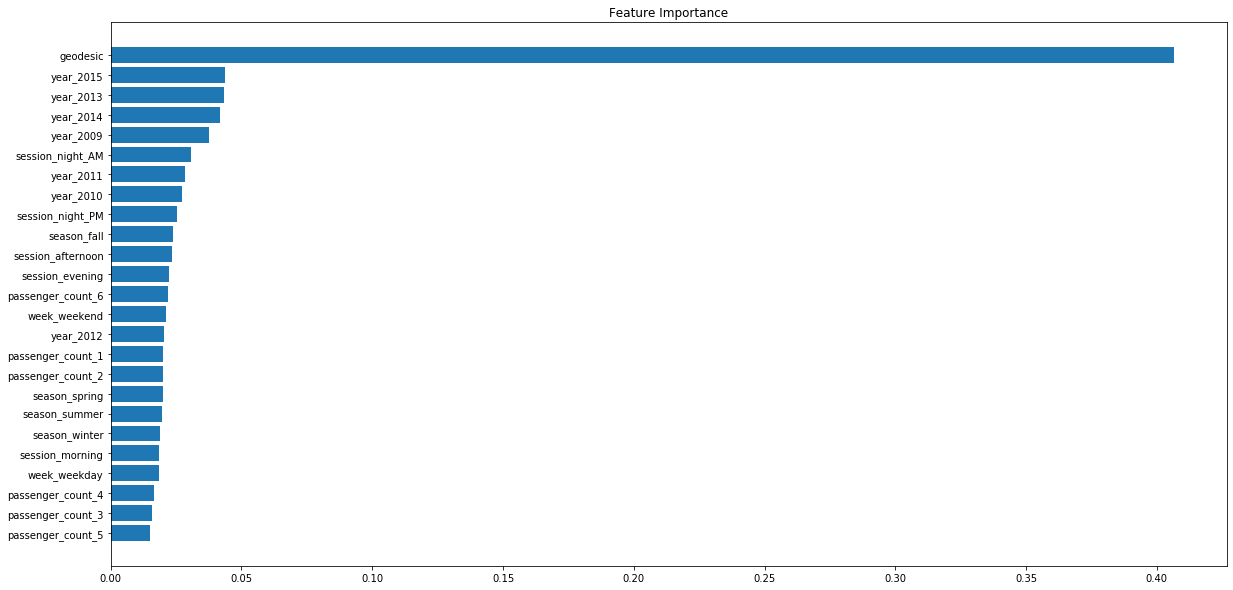

<<<------------------- Training Data Score --------------------->

r square   0.7542601370011739
Adjusted r square:0.7537359031437654
MAPE:18.030639321949952
MSE: 4.887567502409207
RMSE: 2.2107843636160465
RMSLE: 0.20422186998519856

<<<------------------- Test Data Score --------------------->

r square   0.7560534064108082
Adjusted r square:0.7544852231144005
MAPE:18.262851451779472
MSE: 5.001841484581821
RMSE: 2.236479708063952
RMSLE: 0.20556337417589995


In [141]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.1, reg_alpha= 0.08685113737513521, n_estimators= 200, max_depth= 3, learning_rate=0.05, colsample_bytree= 0.7000000000000001, colsample_bynode=0.7000000000000001, colsample_bylevel=0.9000000000000001)

# Fit the regressor to the data
Xgb.fit(X_train,y_train)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

# Sort feature importances in descending order
indices = np.argsort(xgb_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),xgb_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig(' xgb feature importance')
plt.show()# Make predictions
test_scores(Xgb)

In [142]:
# Finalize model
# Create standalone model on entire training dataset
# Save model for later use
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def score(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_)))
    print('RMSLE:',rmsle(y_test,y_pred))
def scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X)
    score(y,y_pred)
    print('RMSLE:',rmsle(y,y_pred))

In [143]:
test.columns

Index(['passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'week_weekday', 'week_weekend', 'session_afternoon', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2009',
       'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014',
       'year_2015', 'geodesic'],
      dtype='object')

In [144]:
train.columns

Index(['fare_amount', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'week_weekday', 'week_weekend', 'session_afternoon',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2009', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [145]:
train.shape

(15660, 26)

In [146]:
test.shape

(9914, 25)

In [147]:
a=pd.read_csv('test.csv')

In [148]:
test_pickup_datetime=a['pickup_datetime']

[09:27:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.01741217 0.02131905 0.01626815 0.01375871 0.01266569 0.01519891
 0.02233749 0.01121703 0.01565513 0.01516344 0.01435225 0.01926658
 0.02414159 0.01990416 0.01930027 0.03093129 0.02183564 0.02739915
 0.0264697  0.02762061 0.01776114 0.04210015 0.05217946 0.03744927
 0.458293  ]


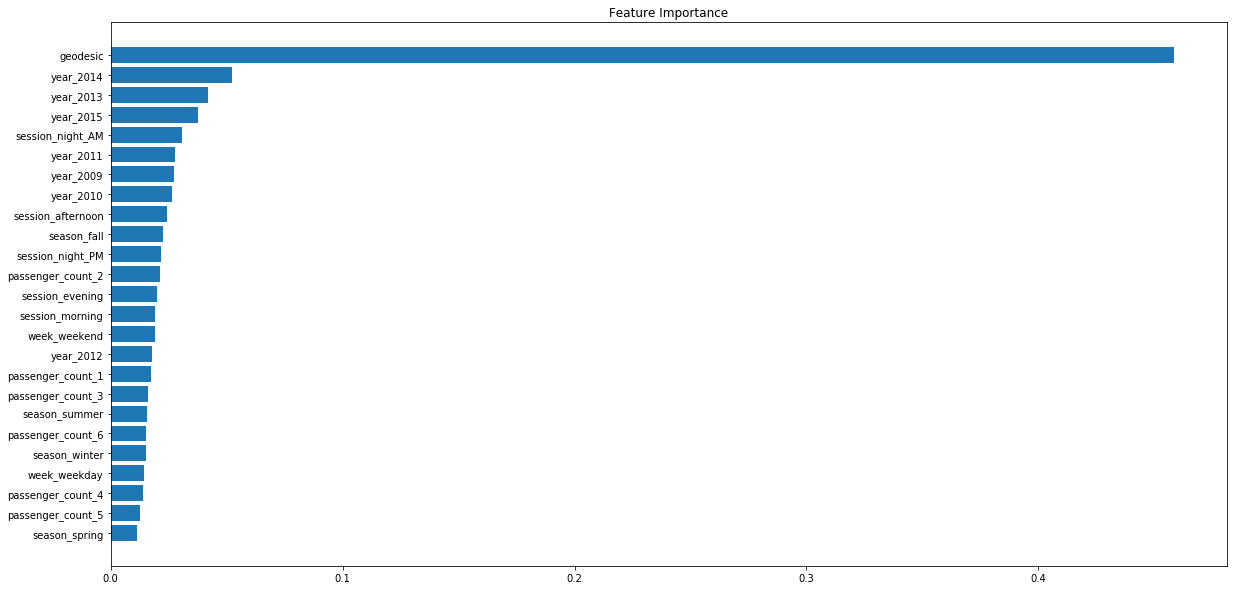

<<<------------------- Training Data Score --------------------->

r square   0.7558132360793244
Adjusted r square:0.755422762170023
MAPE:18.206907049014813
MSE: 4.894230304905707
RMSE: 2.212290736975072
RMSLE: 0.21619763195611283
RMSLE: 0.20443795481193994


In [149]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.1, reg_alpha= 0.08685113737513521, n_estimators= 200, max_depth= 3, learning_rate=0.05, colsample_bytree= 0.7000000000000001, colsample_bynode=0.7000000000000001, colsample_bylevel=0.9000000000000001)

# Fit the regressor to the data
Xgb.fit(X,y)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

# Sort feature importances in descending order
indices = np.argsort(xgb_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),xgb_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig(' xgb1 feature importance')
plt.show()
scores(Xgb)

# Predictions
pred = Xgb.predict(test.values)
pred_results_wrt_date = pd.DataFrame({"pickup_datetime":test_pickup_datetime,"fare_amount" : pred})
pred_results_wrt_date.to_csv("predictions_xgboost.csv",index=False)

In [150]:
pred_results_wrt_date

,pickup_datetime,fare_amount
0,2015-01-27 13:08:24 UTC,5.851055
1,2015-01-27 13:08:24 UTC,5.851055
2,2011-10-08 11:53:44 UTC,5.006139
3,2012-12-01 21:12:12 UTC,6.046586
4,2012-12-01 21:12:12 UTC,4.743369
...,...,...
9909,2015-05-10 12:37:51 UTC,6.097013
9910,2015-01-12 17:05:51 UTC,6.043412
9911,2015-04-19 20:44:15 UTC,7.840034
9912,2015-01-31 01:05:19 UTC,5.665742


In [151]:
joblib.dump(Xgb, 'cab_fare_xgboost_model.pkl') 
  
# # Load the model from the file 
# Xgb_from_joblib = joblib.load('cab_fare_xgboost_model.pkl')

['cab_fare_xgboost_model.pkl']